# Prosper Loan Data Exploration

## Preliminary Wrangling

Prosper is the first peer-to-peer American lending marketplace, with more than 2 million members and over two billion dollars in funded loans. The data set available to the public (last updated on March 11th, 2014) contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others. We will keep only the most important feature to try to answer the questions:

- What factors affect a loan’s outcome status?


- What affects the borrower’s APR or interest rate?


- Are there differences between loans depending on how large the original loan amount was?

In [37]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [38]:
# load in the dataset into a pandas dataframe, print statistics
loan_data = pd.read_csv('prosperLoanData.csv')

In [39]:
# high-level overview of data shape and composition
print(loan_data.shape)
print(loan_data.dtypes)
print(loan_data.head(10))

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


### Feature Pre-Selection:
We will keep only the most important features that could logically impact the loan outcome:

- Term: The length of the loan expressed in months.
- LoanStatus: The current status of the loan: Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.
- BorrowerAPR: The Borrower's Annual Percentage Rate (APR) for the loan.
- ProsperScore: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score.  Applicable for loans originated after July 2009.
- ListingCategory: The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans
- BorrowerState: The two letter abbreviation of the state of the address of the borrower at the time the Listing was created.
- EmploymentStatus:The employment status of the borrower at the time they posted the listing.
- EmploymentStatusDuration: The length in months of the employment status at the time the listing was created.
- IsBorrowerHomeowner: A Borrower will be classified as a homowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner.
- CreditScoreRangeLower: The lower value representing the range of the borrower's credit score as provided by a consumer credit rating agency.
- CreditScoreRangeUpper: The upper value representing the range of the borrower's credit score as provided by a consumer credit rating agency. 
- OpenRevolvingMonthlyPayment: Monthly payment on revolving accounts at the time the credit profile was pulled.
- CurrentDelinquencies: Number of accounts delinquent at the time the credit profile was pulled.
- AmountDelinquent: Dollars delinquent at the time the credit profile was pulled.
- RevolvingCreditBalance: Dollars of revolving credit at the time the credit profile was pulled.
- BankcardUtilization: The percentage of available revolving credit that is utilized at the time the credit profile was pulled.
- AvailableBankcardCredit: The total available credit via bank card at the time the credit profile was pulled.
- DebtToIncomeRatio: The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. This value is capped at 10.01 (any debt to income ratio larger than 1000% will be returned as 1001%).
- IncomeRange: The income range of the borrower at the time the listing was created.
- LoanOriginalAmount: The origination amount of the loan.

In [40]:
#Keep only important features
features = ['Term', 'LoanStatus', 'BorrowerAPR', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState',
            'EmploymentStatus','EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CreditScoreRangeLower',
            'CreditScoreRangeUpper', 'OpenRevolvingMonthlyPayment', 'CurrentDelinquencies', 'AmountDelinquent',
            'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'DebtToIncomeRatio',
            'IncomeRange', 'LoanOriginalAmount']
loan_data = loan_data[features]

In [41]:
# Rename 'ListingCategory (numeric)' to 'ListingCategory'
loan_data['ListingCategory (numeric)'] = loan_data['ListingCategory (numeric)'].apply(str)
loan_data = loan_data.rename(index=str, columns={'ListingCategory (numeric)': "ListingCategory"})

In [42]:
# convert LoanStatus, ListingCategory, BorrowerState, EmploymentStatus and IncomeRange into ordered categorical types
ordinal_var_dict = {'LoanStatus': ['Current','Completed','Chargedoff','Defaulted', 'FinalPaymentInProgress',
                                   'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)',
                                   'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (>120 days)'],
                    'ListingCategory': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
                                        '13', '14', '15', '16', '17', '18', '19', '20'],
                    'BorrowerState': ['CA', 'NY', 'TX', 'FL', 'IL', 'OH', 'GA', 'VA', 'NJ', 'PA', 'MI', 'NC',
                                      'MD', 'WA', 'MA', 'MO', 'MN', 'CO', 'IN', 'TN', 'WI', 'CT', 'AZ', 'AL',
                                      'OR', 'NV', 'SC', 'KY', 'KS', 'LA', 'AR', 'OK', 'MS', 'NE', 'UT', 'NH',
                                      'RI', 'ID', 'DC', 'HI', 'NM', 'WV', 'DE', 'MT', 'SD', 'VT', 'AK', 'WY'],
                    'EmploymentStatus': ['Employed', 'Full-time', 'Part-time', 'Self-employed', 'Not employed',
                                         'Retired', 'Other'], 
                    'IncomeRange': ['Not employed', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
                                    '$75,000-99,999', '$100,000+']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    loan_data[var] = loan_data[var].astype(ordered_var)
loan_data = loan_data.dropna().reset_index()


In [43]:
# descriptive statistics for numeric variables
print(loan_data.describe())

               Term   BorrowerAPR  ProsperScore  EmploymentStatusDuration  \
count  77543.000000  77543.000000  77543.000000              77543.000000   
mean      42.724630      0.223727      6.062030                104.240757   
std       11.712344      0.079159      2.362402                 96.790960   
min       12.000000      0.045830      1.000000                  0.000000   
25%       36.000000      0.161750      4.000000                 31.000000   
50%       36.000000      0.215660      6.000000                 75.000000   
75%       60.000000      0.287800      8.000000                149.000000   
max       60.000000      0.423950     11.000000                755.000000   

       CreditScoreRangeLower  CreditScoreRangeUpper  \
count           77543.000000           77543.000000   
mean              699.002618             718.002618   
std                47.161527              47.161527   
min               600.000000             619.000000   
25%               660.000000   

In [44]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77543 entries, 0 to 77542
Data columns (total 21 columns):
index                          77543 non-null object
Term                           77543 non-null int64
LoanStatus                     77543 non-null category
BorrowerAPR                    77543 non-null float64
ProsperScore                   77543 non-null float64
ListingCategory                77543 non-null category
BorrowerState                  77543 non-null category
EmploymentStatus               77543 non-null category
EmploymentStatusDuration       77543 non-null float64
IsBorrowerHomeowner            77543 non-null bool
CreditScoreRangeLower          77543 non-null float64
CreditScoreRangeUpper          77543 non-null float64
OpenRevolvingMonthlyPayment    77543 non-null float64
CurrentDelinquencies           77543 non-null float64
AmountDelinquent               77543 non-null float64
RevolvingCreditBalance         77543 non-null float64
BankcardUtilization          

### What is the structure of your dataset?


After a first screening, there are 77543 loan listings in the dataset with 23 features (17 numerical features and 6 categorical features). Most variables are numerical (17 against 6 categorical),the 6 categorical variables 'LoanStatus', 'ListingCategory', 'BorrowerState', 'EmploymentStatus', 'IsBorrowerHomeowner', 'IncomeRange'are factor variables with the following levels.

- LoanStatus: 
            - Cancelled
            - Chargedoff
            - Completed
            - Current
            - Defaulted
            - FinalPaymentInProgress
            - PastDue
            
- ListingCategory:  
                    - 0 Not Available, 
                    - 1 Debt Consolidation
                    - 2 Home Improvement
                    - 3 Business
                    - 4 Personal Loan
                    - 5 Student Use
                    - 6 Auto
                    - 7 Other
                    - 8 Baby&Adoption
                    - 9 Boat 
                    - 10 Cosmetic Procedure
                    - 11 Engagement Ring
                    - 12 Green Loans 
                    - 13 Household Expenses
                    - 14 Large Purchases 
                    - 15 Medical/Dental
                    - 16 Motorcycle
                    - 17 RV
                    - 18 Taxes
                    - 19 Vacation
                    - 20 Wedding Loans
- BorrowerState: The two letter abbreviation of the state of the address of the borrower at the time the Listing was created.
- EmploymentStatus: 
                    - Employed
                    - Full-time
                    - Part-time
                    - Self-employed
                    - Not employed
                    - Retired
                    - Other
                    
- IsBorrowerHomeowner:  
                        - 0 Not home owner
                        - 1 Home owner
                        
- IncomeRange (ordered variable): 
                - 100,000+
                - 75,000 - 99,999
                - 50,000 - 74,999
                - 25,000 - 49,999
                - 1 - 24,999
                - Not employed

### What is/are the main feature(s) of interest in your dataset?

In this EDA we will try to answer the questions:
- What factors affect a loan’s outcome status?
- What affects the borrower’s APR or interest rate?
- Are there differences between loans depending on how large the original loan amount was?

Considering this, we could say that we have 3 main features of interest; the loan amount, the interest rate and the loan status

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

We expect that the income range, the loan original amount, the term, debt to income ratio, prosper score and credit score will have the strongest effect on the the borrower’s APR and the loan outcome status.

## Univariate Exploration
### Loan original amount:
We will start by looking at the distribution of the main variable of interest: the original loan amount.

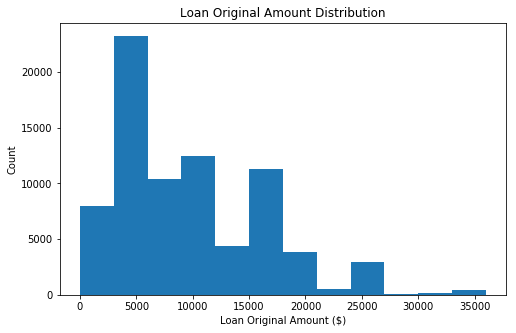

In [45]:
# start with a standard-scaled plot
binsize = 3000
bins = np.arange(0, loan_data['LoanOriginalAmount'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_data, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Original Amount ($)')
plt.ylabel('Count')
plt.title('Loan Original Amount Distribution')
plt.show()

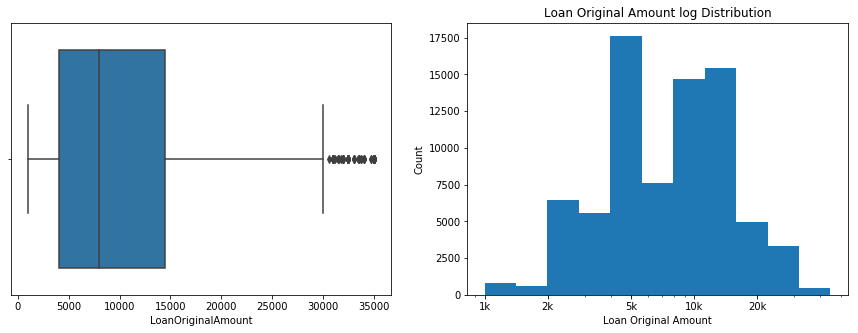

In [46]:
# there's a long tail in the distribution, so let's put it on a log scale instead
plt.figure(figsize = [15, 5])
plt.subplot(1, 2, 1)
sb.boxplot(data = loan_data, x = 'LoanOriginalAmount', color = sb.color_palette()[0])


plt.subplot(1, 2, 2)
log_binsize = 0.15
bins = 10 ** np.arange(np.log10(loan_data['LoanOriginalAmount'].min()), np.log10(loan_data['LoanOriginalAmount'].max())+log_binsize, log_binsize)
plt.hist(data = loan_data, x = 'LoanOriginalAmount', bins = bins)
plt.xscale('log')
plt.xticks([1e3, 2e3, 5e3, 1e4, 2e4], ['1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Loan Original Amount')
plt.ylabel('Count')
plt.title('Loan Original Amount log Distribution')
plt.show()

In [47]:
len(loan_data[loan_data['LoanOriginalAmount']>30000])

503

Loan Original Amount has a skewed distribution, with a lot of loans between 5k and 10k , and few higher than 30k. When plotted on a log-scale, the price distribution looks roughly bimodal, with one peak around 5k, and a second peak a little between 8k and 15k. We notice also that there are 503 outliers with loan amount higher than 30k.
### Borrower APR:
Next up, the second variable of interest: interest rate.

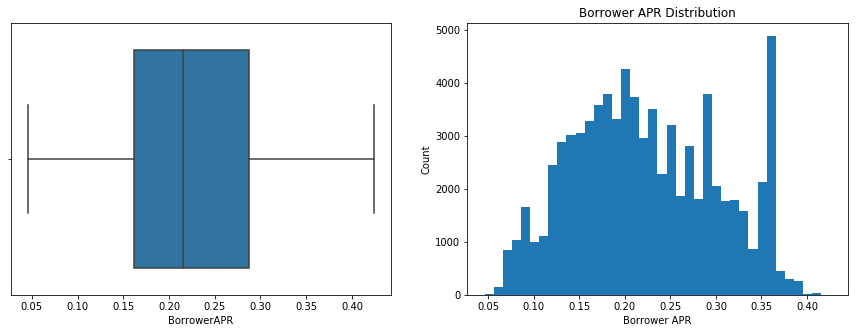

In [48]:
plt.figure(figsize = [15, 5])
plt.subplot(1, 2, 1)
sb.boxplot(data = loan_data, x = 'BorrowerAPR', color = sb.color_palette()[0])


plt.subplot(1, 2, 2)
binsize = 0.01
bins = np.arange(loan_data['BorrowerAPR'].min(), loan_data['BorrowerAPR'].max()+binsize, binsize)
plt.hist(data = loan_data, x = 'BorrowerAPR', bins = bins)
plt.xlabel('Borrower APR')
plt.ylabel('Count')
plt.title('Borrower APR Distribution')
plt.show()

Except for values around 35%, the distribution of the Borrower APR variable has a bell-like shape. 36% is the most frequent rate and 21% is the mean rate.
### Loan status:
Now lets see the distribution of the third main feature: the loan status.

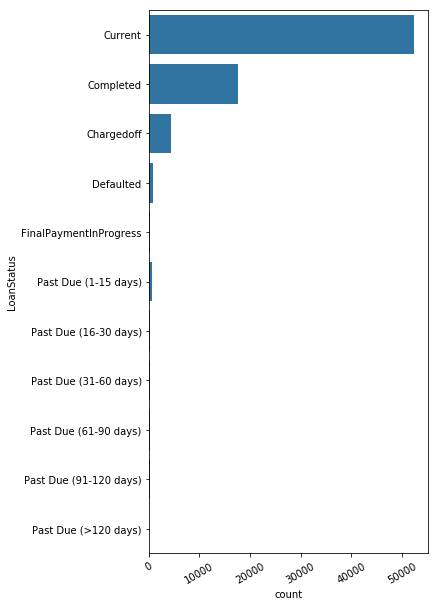

In [49]:
plt.figure(figsize = [5, 10])
sb.countplot(data = loan_data, y = 'LoanStatus', color = sb.color_palette()[0])
plt.xticks(rotation = 30);

In the case of the loan status, current status is the most frequent with more than 5000, next comes completed status with 2000 loan. in third position Charged-off status with about 500 loans, then comes defaulted status with 50 loan and to a lesser extent, the past due status.

Let's now explore the variables that we are expecting to be the most influential:  income range the term, debt to income ratio, prosper score and credit score
### Income Range:

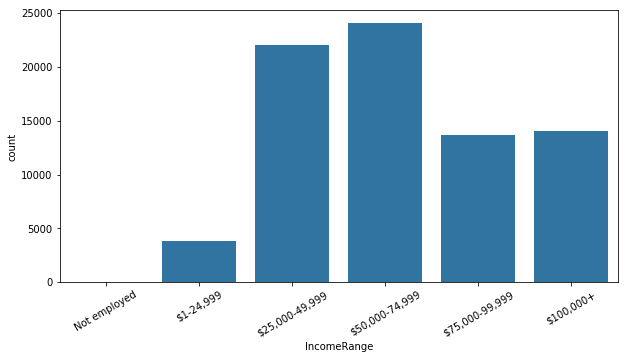

In [50]:
plt.figure(figsize = [10, 5])
sb.countplot(data = loan_data, x = 'IncomeRange', color = sb.color_palette()[0])
plt.xticks(rotation = 30);

The most common Income Range was between 50k and 75k with about 24000 borrowers, then comes the range between 25k and 50k with 22000 borrowers and in the third place we have the ranges [75k, 100k] and [>100k ] with 14000 borrowers approximately

### Debt to income ratio:

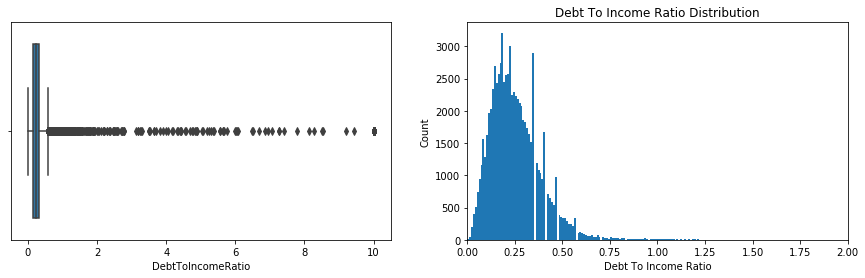

In [51]:
plt.figure(figsize = [15, 4])
plt.subplot(1, 2, 1)
sb.boxplot(data = loan_data, x = 'DebtToIncomeRatio', color = sb.color_palette()[0])


plt.subplot(1, 2, 2)
binsize = 0.01
bins = np.arange(loan_data['DebtToIncomeRatio'].min(), loan_data['DebtToIncomeRatio'].max()+binsize, binsize)
plt.hist(data = loan_data, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt To Income Ratio')
plt.ylabel('Count')
plt.title('Debt To Income Ratio Distribution')
plt.xlim([0,2])
plt.show()

Debt To Income Ratio is unimodal, but the distribution is slightly right skewed and look a little narrower than a normal distribution. The box plot show too many outliers with values higher than 0.75.

### Prosper score:

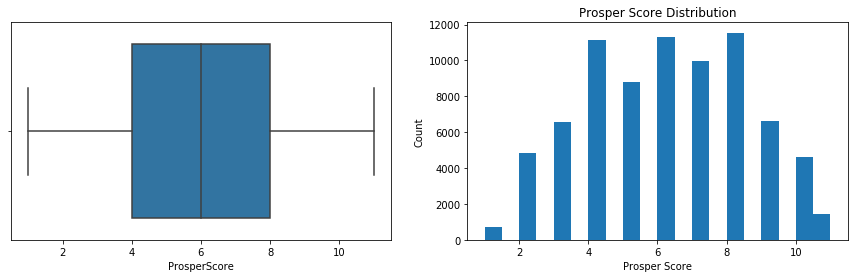

In [52]:
plt.figure(figsize = [15, 4])
plt.subplot(1, 2, 1)
sb.boxplot(data = loan_data, x = 'ProsperScore', color = sb.color_palette()[0])

plt.subplot(1, 2, 2)
binsize = 0.5
bins = np.arange(loan_data['ProsperScore'].min(), loan_data['ProsperScore'].max()+binsize, binsize)
plt.hist(data = loan_data, x = 'ProsperScore', bins = bins)
plt.xlabel('Prosper Score')
plt.ylabel('Count')
plt.title('Prosper Score Distribution')
plt.show()

The distribution of the Prosper Score variable has a bell-like shape. 8 is the most frequent score and 6 is the mean score.

### Credit score:
Let's make some feature engineering with making a new credit score feature defined as the average of CreditScoreRangeLower and CreditScoreRangeUpper

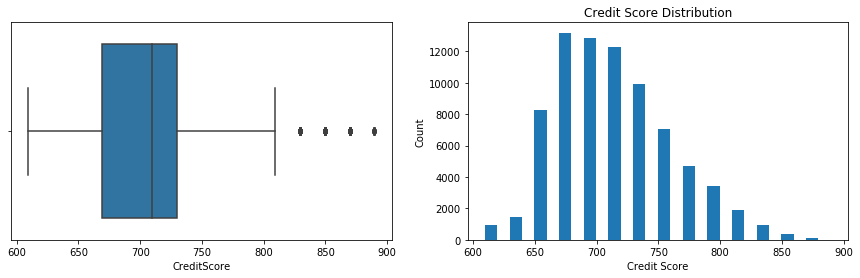

In [53]:
loan_data['CreditScore'] = (loan_data['CreditScoreRangeLower'] + loan_data['CreditScoreRangeUpper'])/2

plt.figure(figsize = [15, 4])
plt.subplot(1, 2, 1)
sb.boxplot(data = loan_data, x = 'CreditScore', color = sb.color_palette()[0])

plt.subplot(1, 2, 2)
binsize = 10
bins = np.arange(loan_data['CreditScore'].min(), loan_data['CreditScore'].max()+binsize, binsize)
plt.hist(data = loan_data, x = 'CreditScore', bins = bins)
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Credit Score Distribution')
plt.show()

Credit Score Distribution is unimodal, but it seems right skewed. Mean credit score is about 710 and we have few outliers with score higher than 810, but they seems to be consistent.

### The terms number:

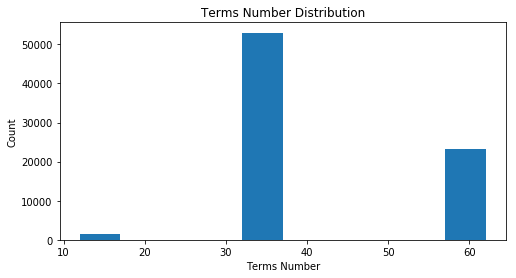

In [54]:
plt.figure(figsize = [8, 4])

binsize = 5
bins = np.arange(loan_data['Term'].min(), loan_data['Term'].max()+binsize, binsize)
plt.hist(data = loan_data, x = 'Term', bins = bins)
plt.xlabel('Terms Number')
plt.ylabel('Count')
plt.title('Terms Number Distribution')
plt.show()

The distribution of the number of terms show that prosper bank allow only 12, 36 or 60 months loans, with 36 months loans being most frequent (over 50000 loans) then comes 60 months loans with about 25000 and finally 12 months loans with about 1200 loans

Let's try to know more about the borrowers, from which state are they? what is there employment status and its duration? are they home owner?  and finally why to borrow?
### Borrower State:

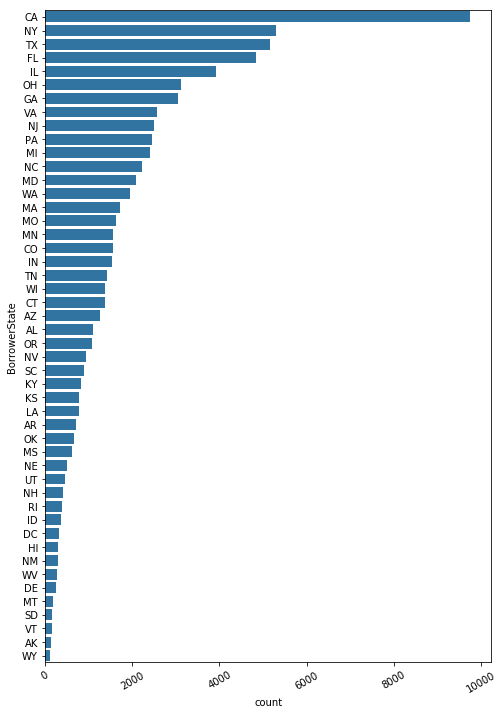

In [55]:
plt.figure(figsize = [8, 12])
sb.countplot(data = loan_data, y = 'BorrowerState', color = sb.color_palette()[0])
plt.xticks(rotation = 30);

Borrower state distribution shows California far ahead with about 10000 borrower than New York and Texas with about 5500 borrower... These results could be explained by the higher population density.

### Employment status and duration

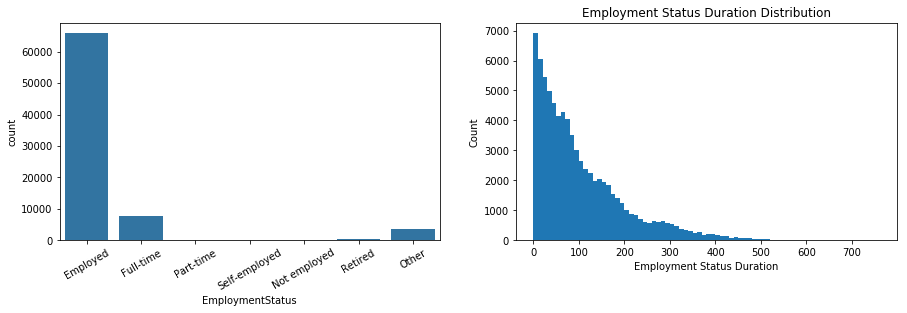

In [56]:
plt.figure(figsize = [15, 4])
plt.subplot(1, 2, 1)
sb.countplot(data = loan_data, x = 'EmploymentStatus', color = sb.color_palette()[0])
plt.xticks(rotation = 30)

plt.subplot(1, 2, 2)
binsize = 10
bins = np.arange(loan_data['EmploymentStatusDuration'].min(), loan_data['EmploymentStatusDuration'].max()+binsize, binsize)
plt.hist(data = loan_data, x = 'EmploymentStatusDuration', bins = bins)
plt.xlabel('Employment Status Duration')
plt.ylabel('Count')
plt.title('Employment Status Duration Distribution')
plt.show()

Employment status distribution shows that over 80% of the borrower are employed (about 70000), employment duration look like a geometric distribution with a mean of 104 months.

### Home Owner:

Text(0.5, 1.0, 'Home Owner Distribution')

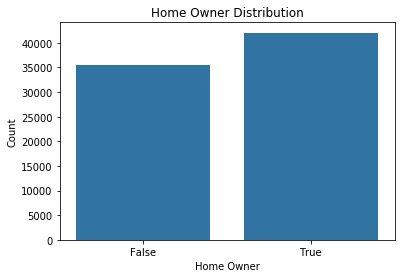

In [57]:
sb.countplot(data = loan_data, x = 'IsBorrowerHomeowner', color = sb.color_palette()[0])
plt.xlabel('Home Owner')
plt.ylabel('Count')
plt.title('Home Owner Distribution')

### Listing Category:

Text(0.5, 1.0, 'Category Distribution')

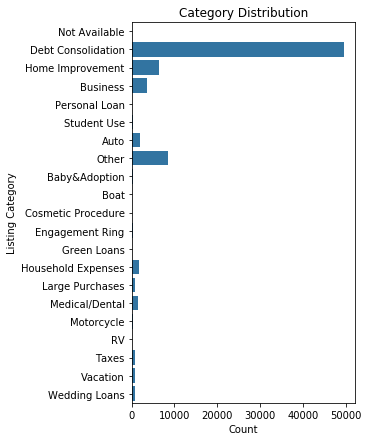

In [58]:
plt.figure(figsize = [4, 7])
sb.countplot(data = loan_data, y = 'ListingCategory', color = sb.color_palette()[0])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
           ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use',
            'Auto', 'Other', 'Baby&Adoption', 'Boat' , 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans',
            'Household Expenses', 'Large Purchases', 'Medical/Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
            'Wedding Loans'])
plt.ylabel('Listing Category')
plt.xlabel('Count')
plt.title('Category Distribution')

paradoxically, by far the most widespread listing category is 'Debt Consolidation' with a little less than 50000 loans, next comes category 'others' with about 8000 loan and in the third place 'home improvement' with about 6000 loans, then comes business and auto with  about 3000 and 1500 respectively.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

- Loan Original Amount has a skewed distribution, with a lot of loans between 5k and 10k , and few higher than 30k. When plotted on a log-scale, the price distribution looks roughly bimodal, with one peak around 5k, and a second peak a little between 8k and 15k. We notice also that there are 503 outliers with loan amount higher than 30k but they seem to be consistent.
- Debt To Income Ratio and Credit Score Distribution are unimodal, but their distribution is slightly right skewed. Credit Score we have few outliers with score higher than 810, but they seem to be consistent.
- Except for values around 35%, the distribution of the Borrower APR variable has a bell-like shape as well as Prosper Score.
- Finally, Employment status duration look like a geometric distribution.


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Loan Original Amount and Credit Score shows outliers with values higher than 30k  and 810 respectively. But we decided to keep them because they were consistent. Debt To Income Ratio box plot show too many outliers with values higher than 0.75, but we could not remove them because they are coherent with the context.

## Bivariate Exploration

To start, we will take a look at the pairwise correlations present between features in the data.

In [59]:
num_features = ['Term', 'BorrowerAPR', 'ProsperScore', 'EmploymentStatusDuration', 'CreditScore',
                'OpenRevolvingMonthlyPayment', 'CurrentDelinquencies','AmountDelinquent',
                'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit',
                'DebtToIncomeRatio', 'LoanOriginalAmount']
cat_features = ['LoanStatus', 'ListingCategory', 'BorrowerState', 'EmploymentStatus', 'IsBorrowerHomeowner', 'IncomeRange']

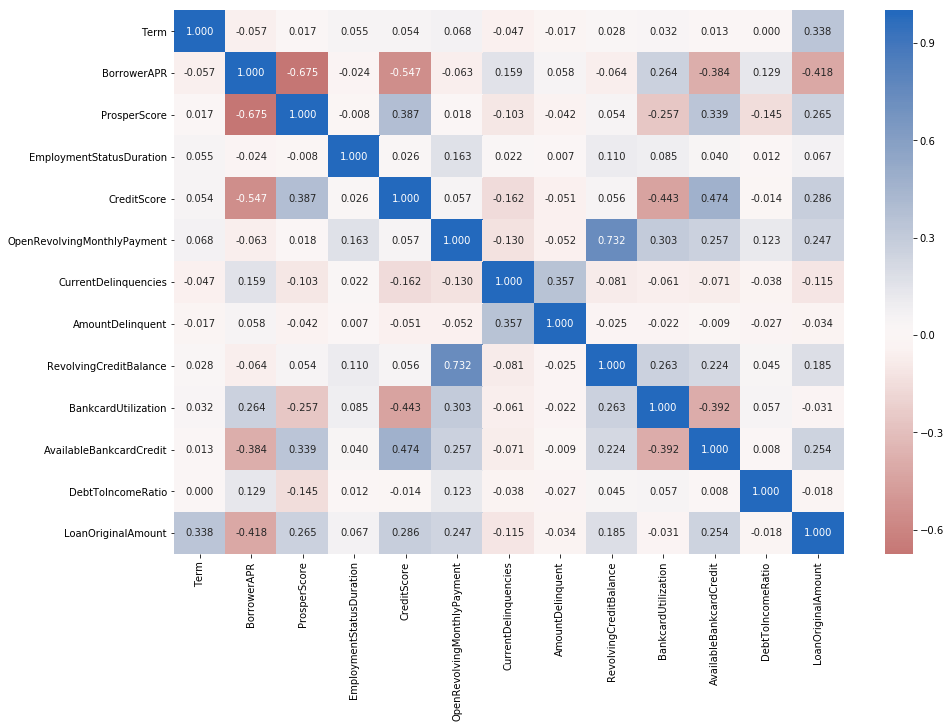

In [60]:
plt.figure(figsize = [15, 10])
sb.heatmap(loan_data[num_features].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

In [61]:
main_num_features = ['BorrowerAPR', 'ProsperScore', 'EmploymentStatusDuration', 'CreditScore',
                'DebtToIncomeRatio', 'LoanOriginalAmount']

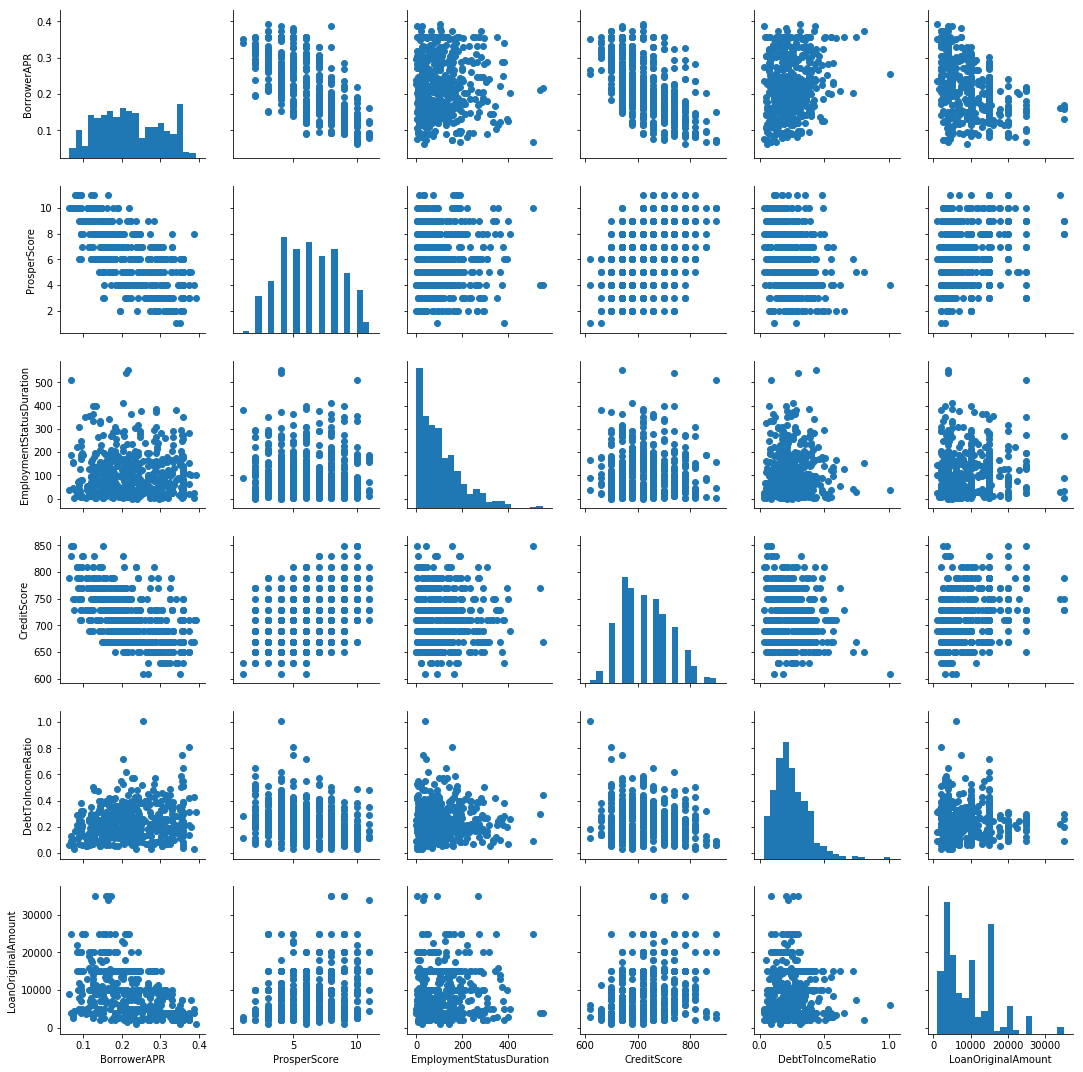

In [62]:
# plot matrix: sample 500 loan_data so that plots are clearer and
# they render faster
samples = np.random.choice(loan_data.shape[0], 500, replace = False)
loan_data_samp = loan_data.loc[samples,:]

g = sb.PairGrid(data = loan_data_samp, vars = main_num_features)
g = g.map_diag(plt.hist, bins = 20)
g.map_offdiag(plt.scatter);

From the correlation matrix and the pair grid between numerical features, we can conclude that there is a moderate negative correlation between borrower APR and Prosper score, The same applies to borrower APR correlation with Credit Score.

Surprisingly, the correlation coefficient between borrower APR and LoanOriginalAmount is a moderate negative correlation, wich means higher loan original amount is expected to have lower borrower APR. 

Let's move on to the correlation between the main numerical features and the categorical variables.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


<Figure size 720x720 with 0 Axes>

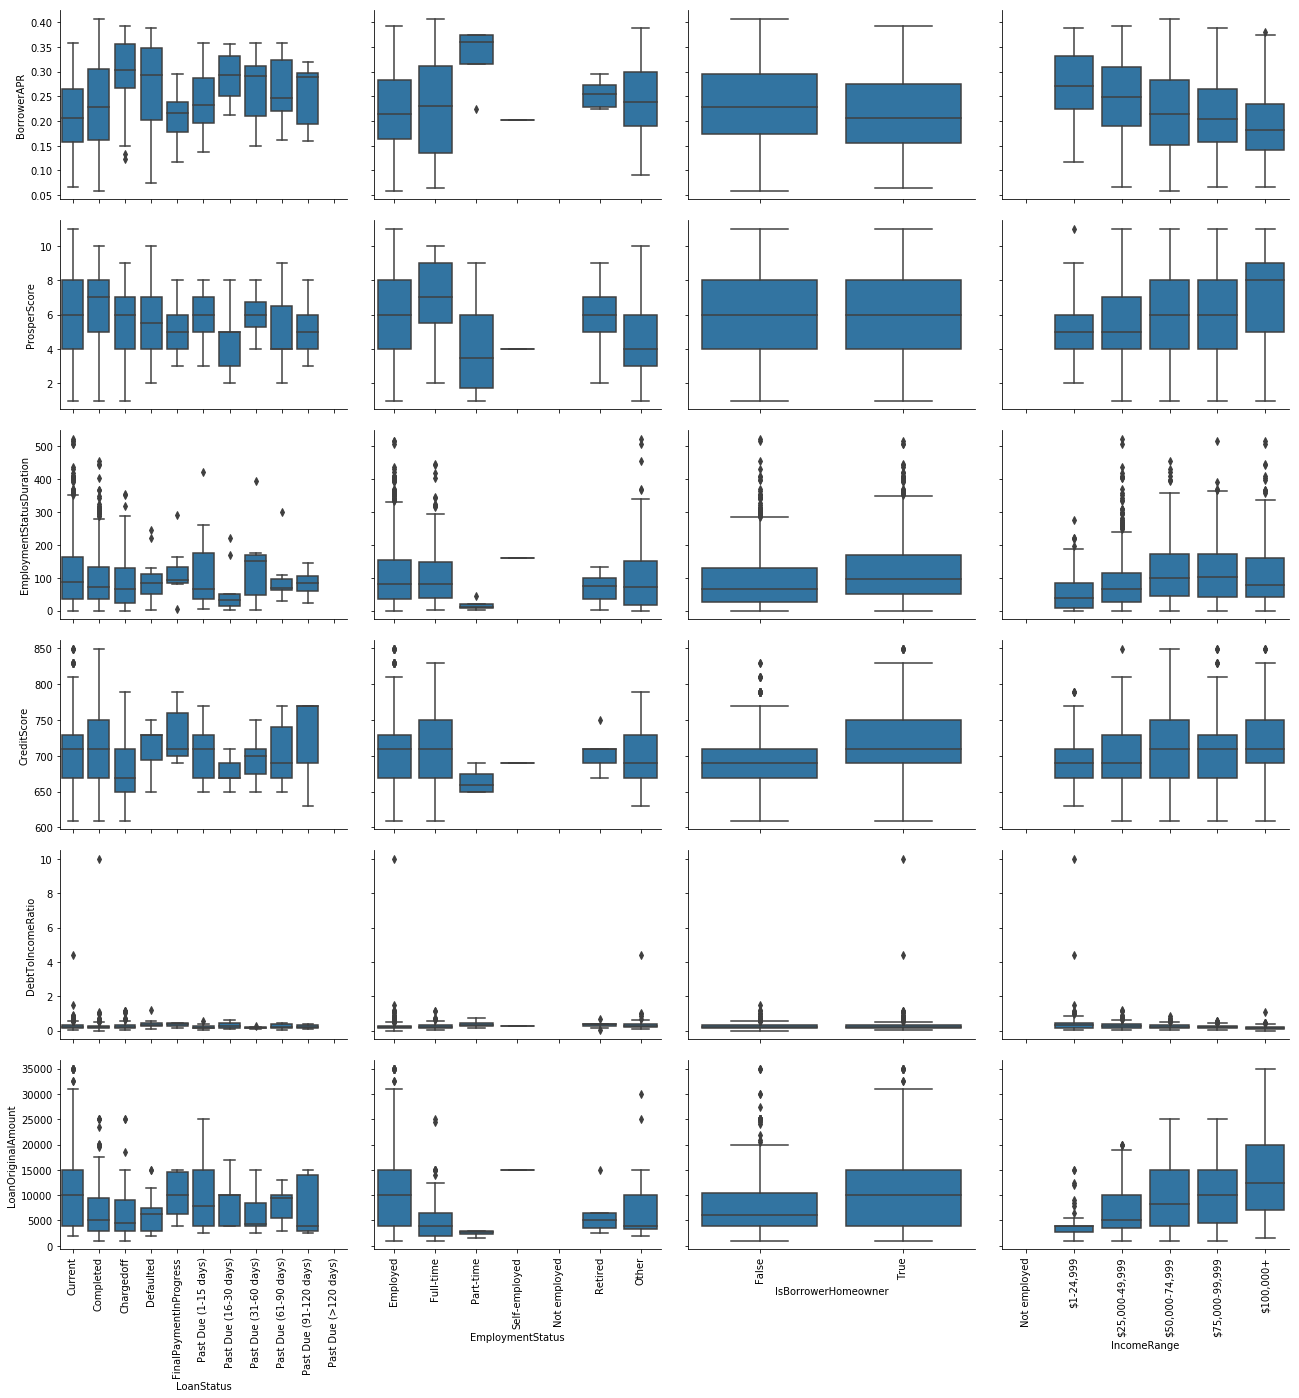

In [63]:
# plot matrix of numeric features against categorical features.
samples = np.random.choice(loan_data.shape[0], 2000, replace = False)
loan_data_samp = loan_data.loc[samples,:]

def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)
    plt.xticks(rotation = 90)
cat_features1 = ['LoanStatus', 'EmploymentStatus', 'IsBorrowerHomeowner', 'IncomeRange']
cat_features2 = ['ListingCategory', 'BorrowerState']
plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = loan_data_samp, y_vars = main_num_features, x_vars = cat_features1,
                size = 3, aspect = 1.5)
g.map(boxgrid)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


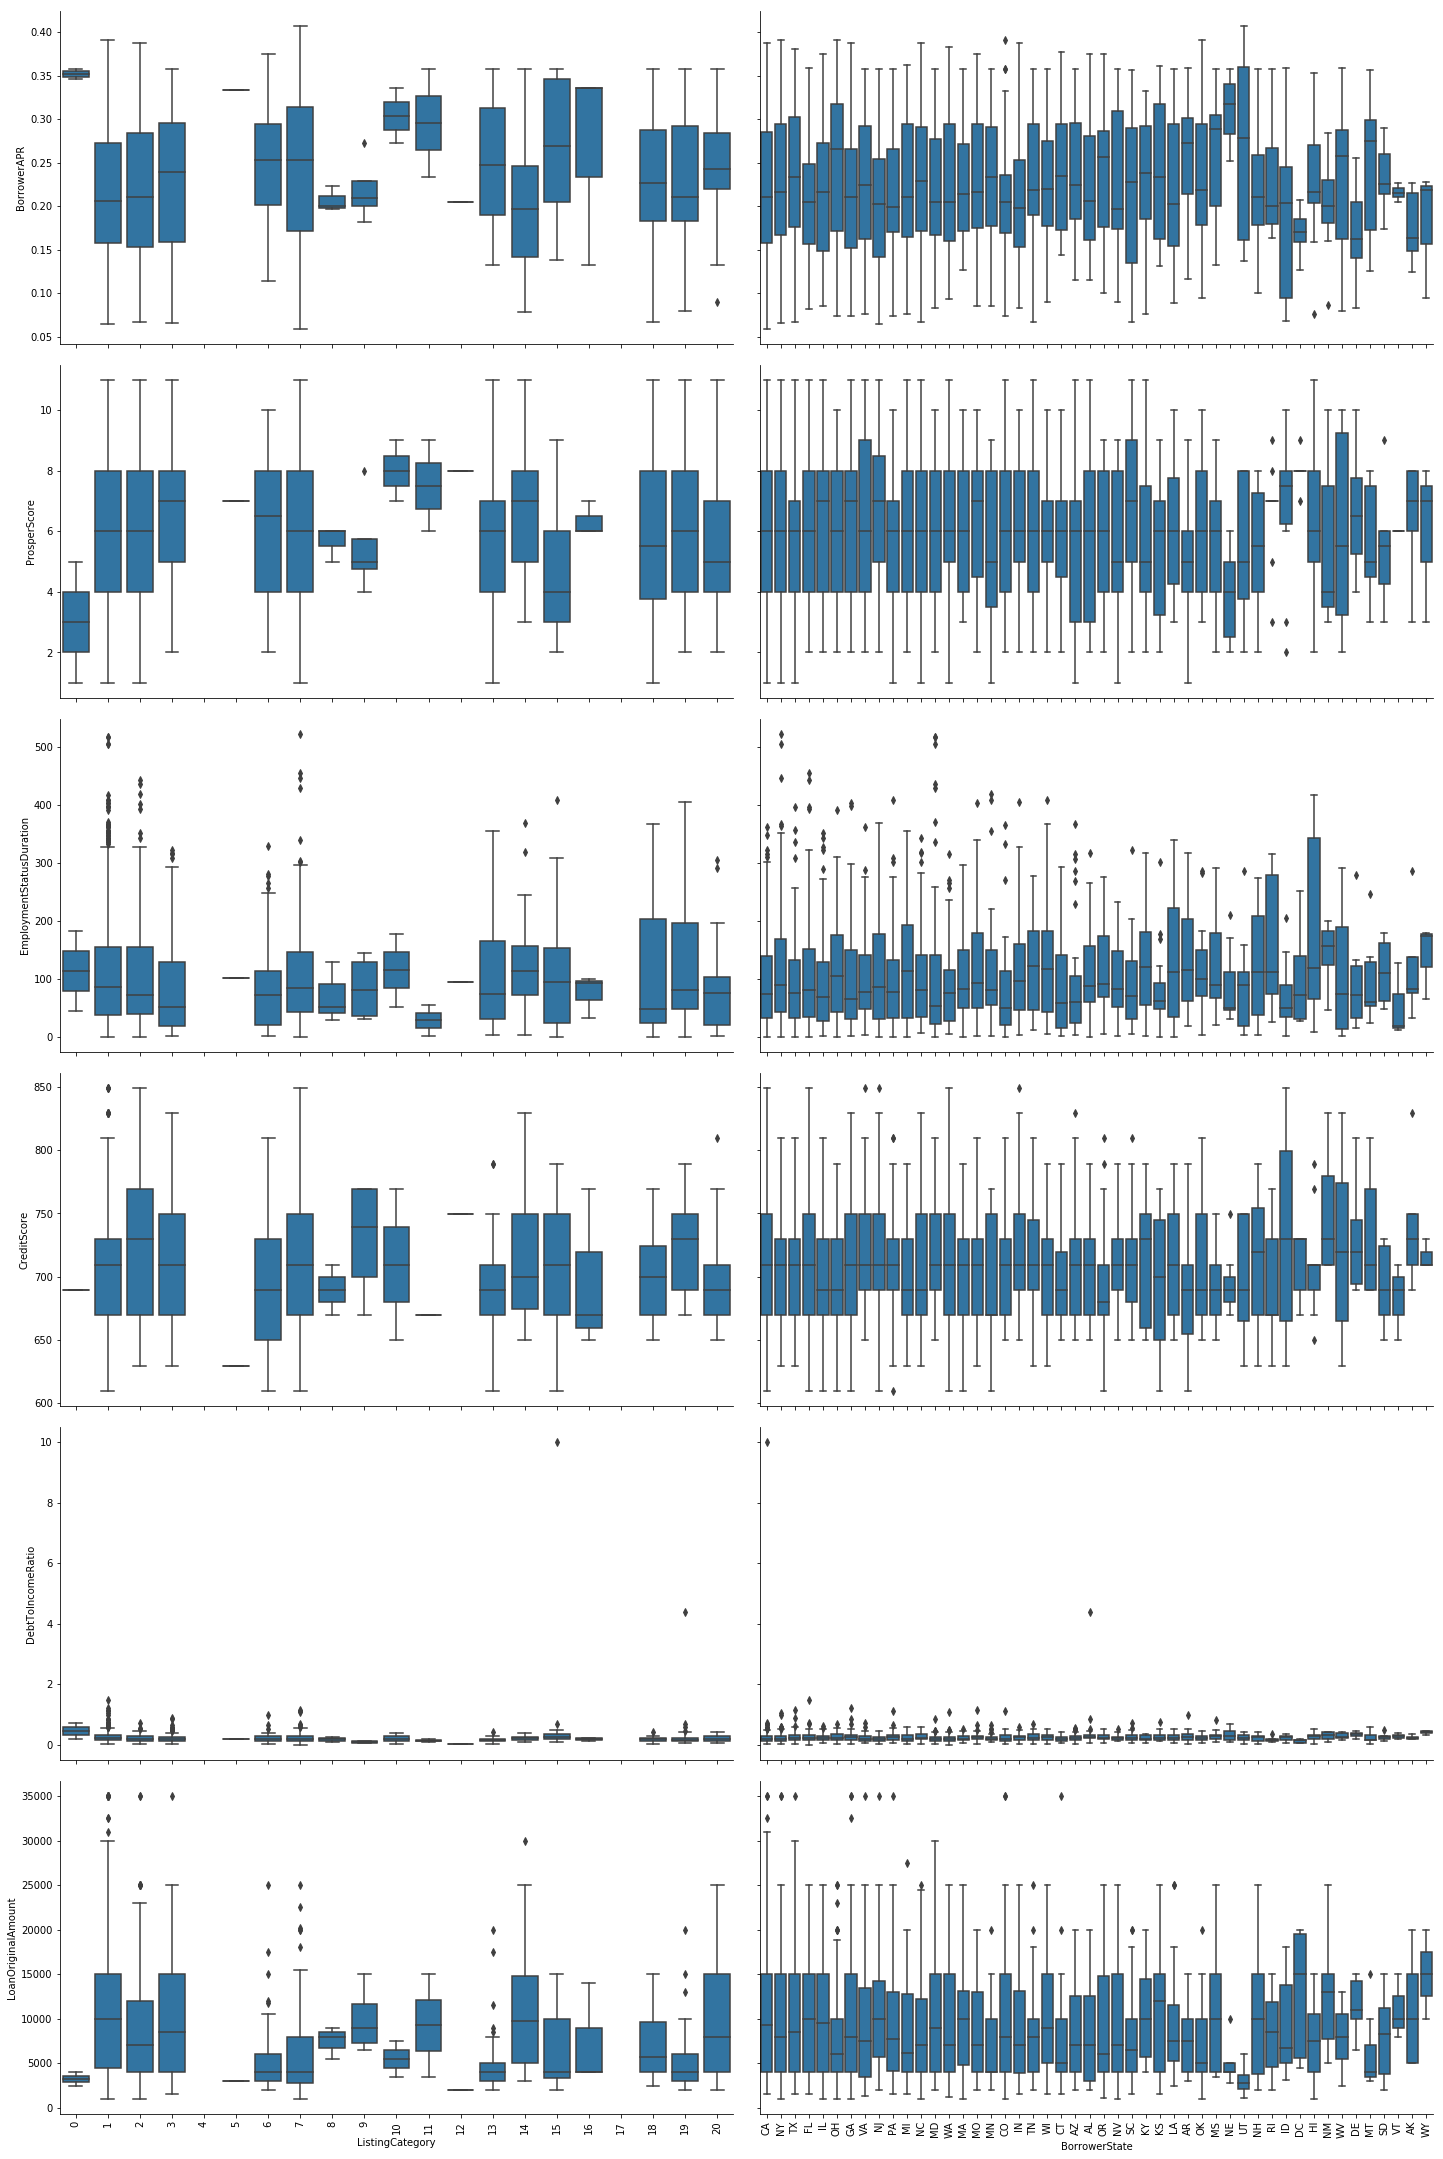

In [64]:
g = sb.PairGrid(data = loan_data_samp, y_vars = main_num_features, x_vars = cat_features2,
                size = 5, aspect = 2)
g.map(boxgrid)
plt.show();

The box plot Pair Grid shows that: 
- The Income range is positively correlated to Prosper score and Loan Original Amount, which means that higher income range correspond to higher Prosper Score and Loan Amounts. On the other hand, Income Range is negatively correlated to Borrower APR, which seems to be reasonable.
- Employment status, show that self employed have higher loans original amount followed by employed status which is more spread. In addition, Full time status has the highest Prosper Score and self employed have the lowest one. Retired status has the highest borrower APR, while other category share the same mean.
- Past due loan status seems to have higher Debt to income ratio. In addition, the higher the income range, the lower the debt to income is. Which is very rational.
- For the loan status, defaulted and past due status show higher borrower APR.
- Regarding the fact that the borrower is a home owner, we notice that homeowners have higher employment duration, higher loans and Credit Score but lower borrower APR.

Finally, let's look at relationships between the categorical features.

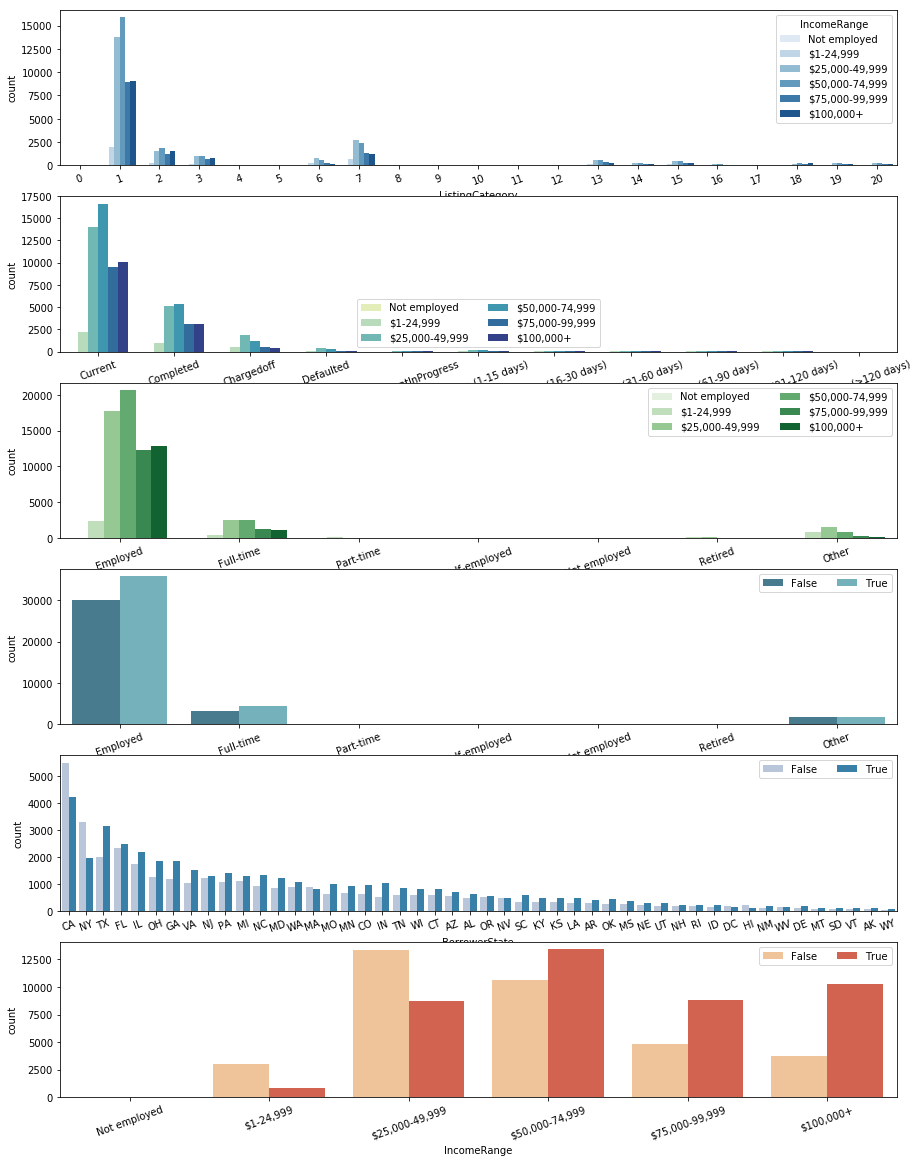

In [65]:
plt.figure(figsize = [15, 20])

# subplot 1:
plt.subplot(6, 1, 1)
sb.countplot(data = loan_data, x = 'ListingCategory', hue = 'IncomeRange', palette = 'Blues')
plt.xticks(rotation = 20)
# subplot 2:
ax = plt.subplot(6, 1, 2)
sb.countplot(data = loan_data, x = 'LoanStatus', hue = 'IncomeRange', palette = 'YlGnBu')
ax.legend(ncol = 2) 
plt.xticks(rotation = 20)
# subplot 3:
ax = plt.subplot(6, 1, 3)
sb.countplot(data = loan_data, x = 'EmploymentStatus', hue = 'IncomeRange', palette = 'Greens')
ax.legend(loc = 1, ncol = 2)
plt.xticks(rotation = 20)
# subplot 4:
ax = plt.subplot(6, 1, 4)
sb.countplot(data = loan_data, x = 'EmploymentStatus', hue = 'IsBorrowerHomeowner', palette = 'GnBu_d')
ax.legend(ncol = 2)
plt.xticks(rotation = 20)
# subplot 5:
ax = plt.subplot(6, 1, 5)
sb.countplot(data = loan_data, x = 'BorrowerState', hue = 'IsBorrowerHomeowner', palette = 'PuBu')
ax.legend(ncol = 2)
plt.xticks(rotation = 20)
# subplot 6:
ax = plt.subplot(6, 1, 6)
sb.countplot(data = loan_data, x = 'IncomeRange', hue = 'IsBorrowerHomeowner', palette = 'OrRd')
ax.legend(ncol = 2)
plt.xticks(rotation = 20)


plt.show()



From the pair plots between categorical features, we found:
- Borrower with Income range between 50k and 75k represents the majority of borrowers with status employed and full time.  Moreover, they hold the biggest part of loans with status current and completed.
- Borrower with Income range between 25 k and 75k are the biggest borrowers in all categories especially for loan consolidation.
- Home owners are the largest part of borrower with employed and full time status. For NY and CA home owner borrowers are fewer than non home owners, unlike other states. This could be explained by the higher cost of real estate. Finally, Borrower with - - Income range between 0 k and 50k mostly non homeowner, while  Borrower with Income range between 50 k and plus are mainly home owners.


### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

From the bivariate exploration, we've observed:
- a moderate negative correlation between borrower APR and Prosper score.
- a moderate negative correlation between borrower APR and LoanOriginalAmount, wich means higher loan original amount is expected to have lower borrower APR.
- Current and completed loan status have lower Borrower APR
- Borrower with Income range between 25 k and 75k are the biggest borrowers in all categories especially for Current loan status.
- For Current and Completed Loan Status there are more home owners. On the other hand, the other categories show a parity between the two.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
Surprisingly, the main reason why people borrow was for loan consolidation. In addition we've seen that Home-owners in NY and CA are fewer than non home owners, unlike other states. This could be explained by the higher cost of real estate.


## Multivariate Exploration
The main purpose of this part is to explore how categorical features like 'IncomeRange', 'EmploymentStatus',  'IsBorrowerHomeowner', 'LoanStatus' and 'ListingCategory' interact with 'BorrowerAPR', 'ProsperScore' and 'DebtToIncomeRatio', 'LoanOriginalAmount'.

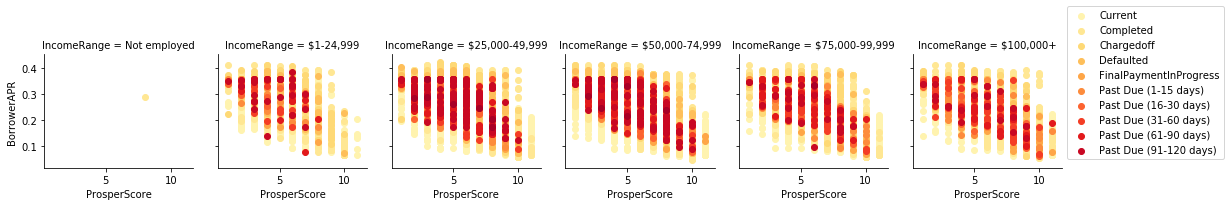

In [66]:
g = sb.FacetGrid(data = loan_data, col = 'IncomeRange',hue = 'LoanStatus',  height = 2.5, margin_titles = True , palette  = 'YlOrRd')
g.map(plt.scatter, 'ProsperScore', 'BorrowerAPR')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75))

The FacetGrid of the BorrowerAPR according to Prosper score for the different IncomeRange categories highlighting LoanStatus confirms that higher BorrowerAPR with lower ProsperScore results in higher probability of Past due Loans. However, lower BorrowerAPR with higher ProsperScore results in lower  probability of Past due Loans, especially for the IncomeRange between 1 and 25k.

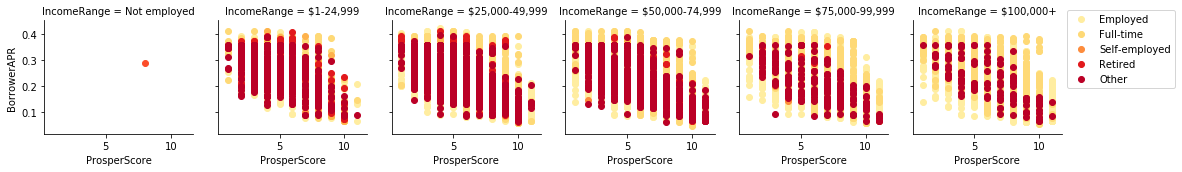

In [67]:
g = sb.FacetGrid(data = loan_data, col = 'IncomeRange', hue = 'EmploymentStatus',  height = 2.5, margin_titles = True , palette  = 'YlOrRd')
g.map(plt.scatter, 'ProsperScore', 'BorrowerAPR')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75))

The FacetGrid of the BorrowerAPR according to Prosper score for the different IncomeRange categories highlighting EmploymentStatus shows that Employed and Full time EmploymentStatus are more likely to have higher IncomeRange than other categories and the higher the IncomeRange lower is the correlation between BorrowerAPR and ProsperScore.

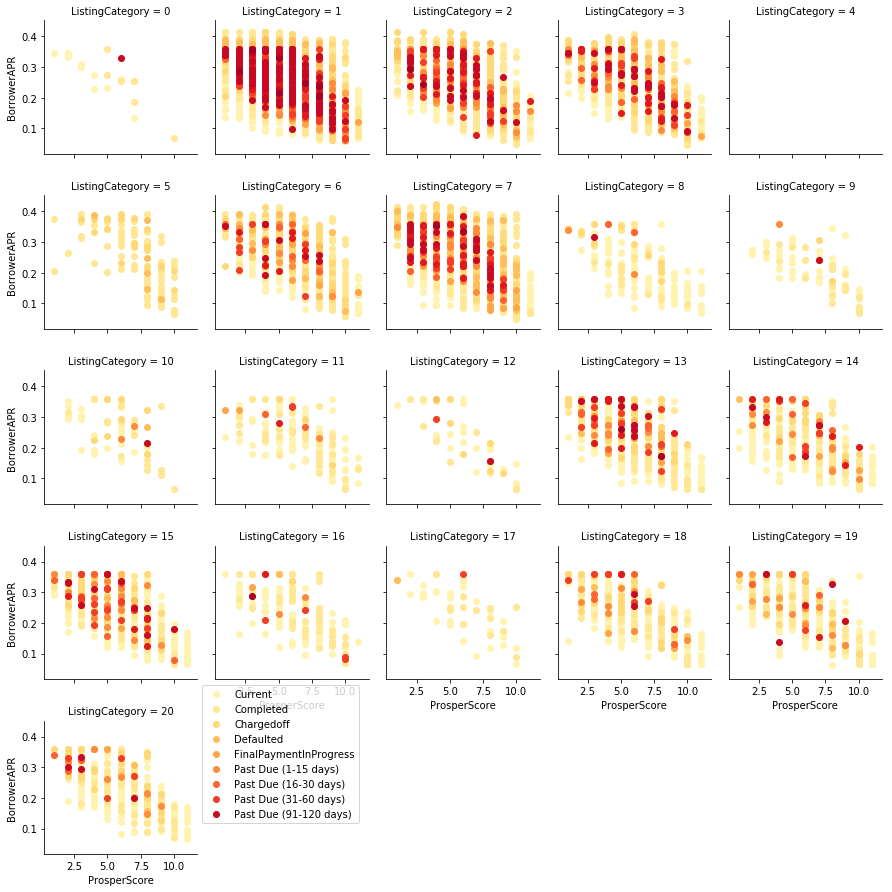

In [68]:
g = sb.FacetGrid(data = loan_data, col = 'ListingCategory', hue = 'LoanStatus',col_wrap = 5,  height = 2.5, margin_titles = True , palette  = 'YlOrRd')
g.map(plt.scatter, 'ProsperScore', 'BorrowerAPR')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75))

The FacetGrid of the BorrowerAPR according to Prosper score for the different Listing categories highlighting LoanStatus shows that Past Due loans are more likely for categories 1 Debt Consolidation, 2 Home Improvement and 7 Other. And for those categories we are more likely to have high ProsperScore with high BorrowerAPR.

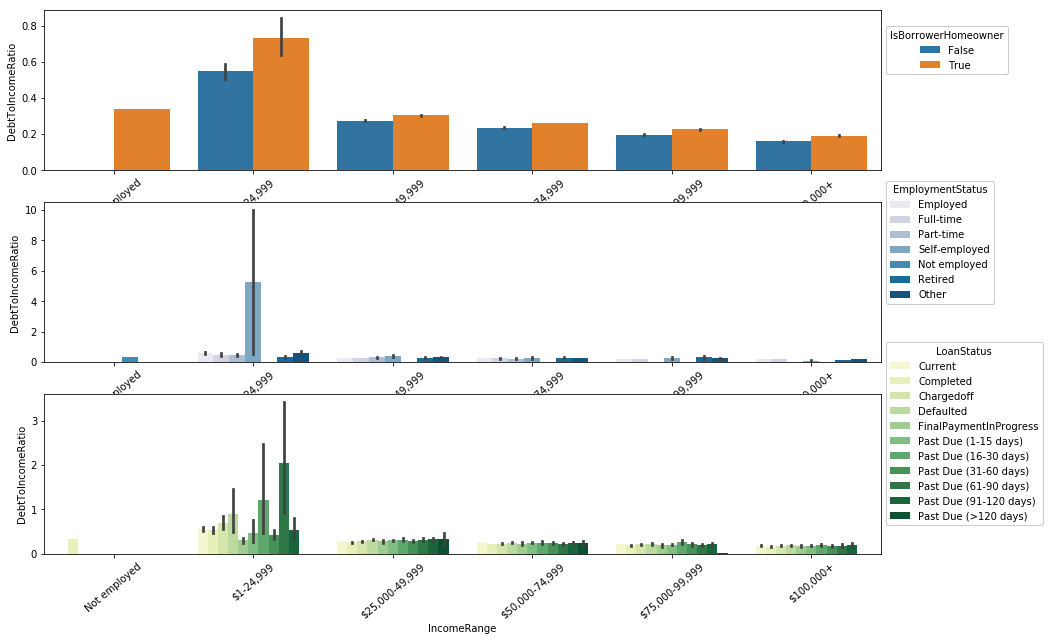

In [69]:
plt.figure(figsize = [15, 10])

# subplot 1:
plt.subplot(3, 1, 1)
ax = sb.barplot(data = loan_data, x = 'IncomeRange', y = 'DebtToIncomeRatio', hue = 'IsBorrowerHomeowner')
plt.xticks(rotation = 40)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75), framealpha = 1, title = 'IsBorrowerHomeowner')
# subplot 2:
plt.subplot(3, 1, 2)
ax = sb.barplot(data = loan_data, x = 'IncomeRange', y = 'DebtToIncomeRatio', hue = 'EmploymentStatus', palette = 'PuBu')
plt.xticks(rotation = 40)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75), framealpha = 1, title = 'EmploymentStatus')
# subplot 3:
plt.subplot(3, 1, 3)
ax = sb.barplot(data = loan_data, x = 'IncomeRange', y = 'DebtToIncomeRatio', hue = 'LoanStatus', palette = 'YlGn')
plt.xticks(rotation = 40)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75), framealpha = 1, title = 'LoanStatus')


From the figures above; we notice that IncomeRange from 1 to 25k have the highest debt to income mean ratio especially for HomeOwners with 0.7 and Past due Loans category reaching 2 times for (91 – 120 days). And it get worse with Self-Employed up to 5 times. On the other hand, we see that the higher IncomeRange the lower the Debt to Income.

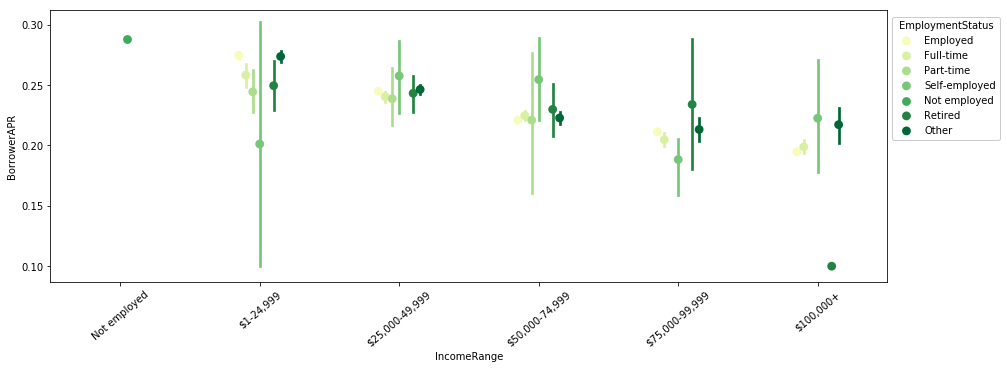

In [70]:
plt.figure(figsize = [15, 5])
ax = sb.pointplot(data = loan_data, x = 'IncomeRange', y = 'BorrowerAPR', hue = 'EmploymentStatus',
                  dodge = 0.3, linestyles = "", palette = 'YlGn')
plt.xticks(rotation = 40)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75), framealpha = 1, title = 'EmploymentStatus')

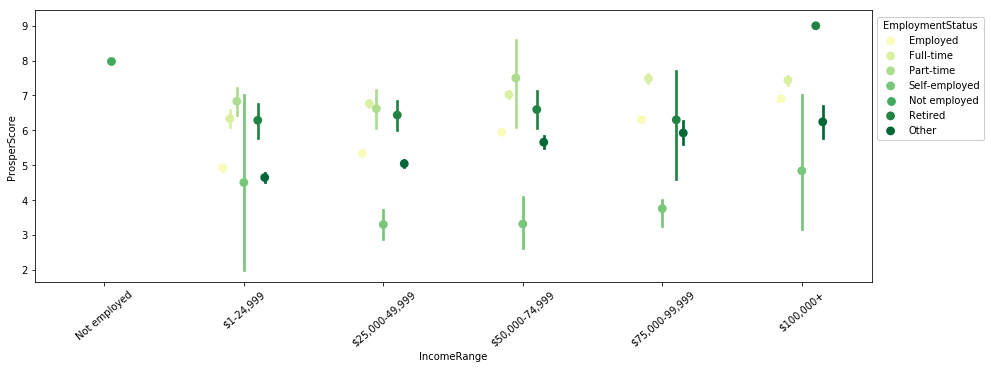

In [71]:
plt.figure(figsize = [15, 5])
ax = sb.pointplot(data = loan_data, x = 'IncomeRange', y = 'ProsperScore', hue = 'EmploymentStatus',
                  dodge = 0.3, linestyles = "", palette = 'YlGn')
plt.xticks(rotation = 40)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75), framealpha = 1, title = 'EmploymentStatus')

The PointPlots shows that Not Employed Status has the lowest ProsperScore and Employed status has the highest ProsperScore for all IncomeRanges. Full time employee with incomeRange higher than 75k could expect a ProsperScore higher than 7 while self employed with income Range between 25k and 100k could expect a ProsperScore between 3 and 4.

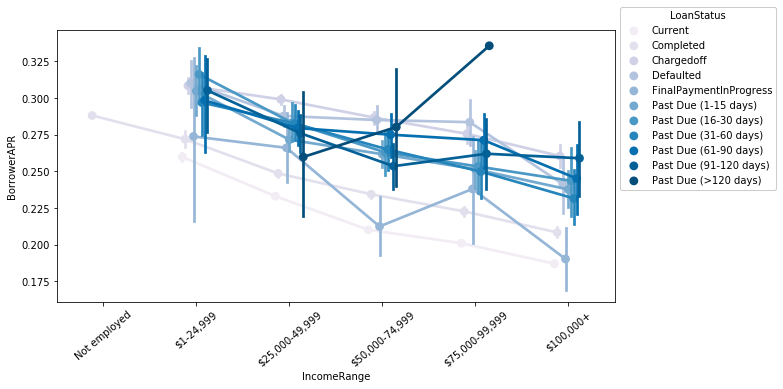

In [72]:
plt.figure(figsize = [10, 5])
ax = sb.pointplot(data = loan_data, x = 'IncomeRange', y = 'BorrowerAPR', hue = 'LoanStatus',
                  dodge = 0.3, linestyles = "-", palette = 'PuBu')
plt.xticks(rotation = 40)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75), framealpha = 1, title = 'LoanStatus')

From the pointplot above we notice that current Loan Status has the lowest BorrowerAPR followed by completed Loan Status. Additionally, we confirm that higher income range results in lower BorrowerAPR.

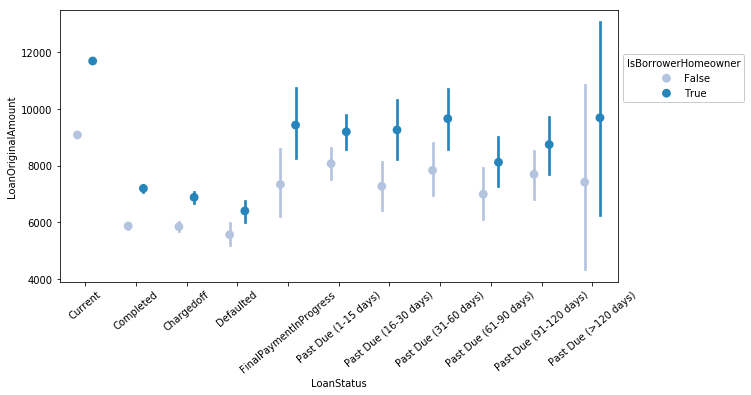

In [73]:
plt.figure(figsize = [10, 5])
ax = sb.pointplot(data = loan_data, x = 'LoanStatus', y = 'LoanOriginalAmount', hue = 'IsBorrowerHomeowner',
                  dodge = 0.3, linestyles = "", palette = 'PuBu')
plt.xticks(rotation = 40)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75), framealpha = 1, title = 'IsBorrowerHomeowner')

This plot shows that regardless of Loan Status Home Owners have higher loan original amount. In addition, Current LoanStutus is the highest one with 11800 Dollars for home owners and 9000 Dollars for non home owners. Finally, Past due (>120 days) is the most widespread with loan original amount ranging from 6000 to 13000 for home owners and 4000 to 11000 for non home owners.

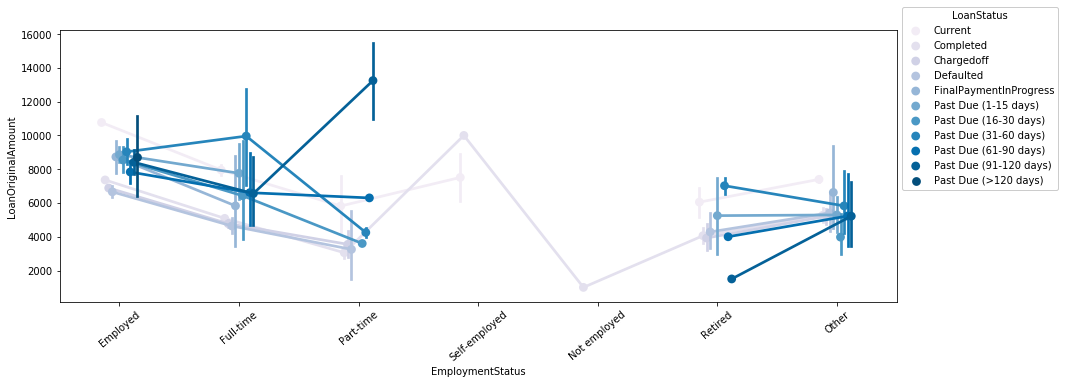

In [74]:
plt.figure(figsize = [15, 5])
ax = sb.pointplot(data = loan_data, x = 'EmploymentStatus', y = 'LoanOriginalAmount', hue = 'LoanStatus',
                  dodge = 0.3, linestyles = "-", palette = 'PuBu')
plt.xticks(rotation = 40)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.75), framealpha = 1, title = 'LoanStatus')

From the previous poinplot, we noted that completed, chargedoff and defaulted categories have the lowest LoanOriginalAmount according to EmploymentStatus.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

We deepened our investigation of ProsperScore, BorrowerAPR, Loan original amount and DebtToIncomeRatio by looking at the impact of the categorical quality features. The multivariate exploration here showed that:
- Higher BorrowerAPR with lower ProsperScore results in higher probability of Past due Loans. However, lower BorrowerAPR with higher ProsperScore results in lower probability of Past due Loans, especially for the IncomeRange between 1 and 25k.
- Employed and Full time EmploymentStatus are more likely to have higher IncomeRange than other categories and the higher the IncomeRange lower is the correlation between BorrowerAPR and ProsperScore.
- Past Due loans are more likely for categories 1 Debt Consolidation, 2 Home Improvement and 7 Other. And for those categories we are more likely to have high ProsperScore with high BorrowerAPR.
- IncomeRange from 1 to 25k have the highest debt to income mean ratio especially for HomeOwners with 0.7 and Past due Loans category reaching 2 times for (91 – 120 days). And it get worse with Self-Employed up to 5 times. On the other hand, we see that the higher IncomeRange the lower the Debt to Income.
- Not Employed Status has the lowest ProsperScore and Employed status has the highest ProsperScore for all IncomeRanges. Full time employee with incomeRange higher than 75k could expect a ProsperScore higher than 7 while self employed with income Range between 25k and 100k could expect a ProsperScore between 3 and 4.
- Current Loan Status has the lowest BorrowerAPR followed by completed Loan Status. Additionally, we confirm that higher income range results in lower BorrowerAPR.
- Completed, charged off and defaulted categories have the lowest LoanOriginalAmount according to EmploymentStatus.


### Were there any interesting or surprising interactions between features?

The interaction between categorical and numerical features in the multivariate exploration showed mostly rational and expected effects. However we expected, higher impact of variables like DebtToIncomeRatio on the BorrowerAPR and ProsperScore.